<font color='2a6f97'>

# Actividad 1 Modelo Predictivo y Tratado de datos - Tips

</font>
Author: Diego Paredero Blanco

Version de python usada: 3.10.11

<font color='ef476f'> ## </font>

<font color='ffd166'> ### </font>

<font color='06d6a0'> #### </font>

<font color='118ab2'> ##### </font>

<font color='2ec4b6'> ###### </font>

<font color='e4c1f9'> ####### </font>


Indice (Los (WIP) aun no estan realiazados y no tienen enlace):
//TODO: estudio con missingno

[Estadisticas y Predicciones](#estadisticas_y_predicciones)
1. [Carga de los datos](#carga_datos)
2. [Analisis Dataset](#analisisinicial)
3. [Tratado de datos null](#tratado_null)
    1. [Eliminacion](#tratado_null_first)
    2. [Relleno](#tratado_null_second)
        1. [Tratado Total Bill](#tratado_null_second_total_bill) 
        2. [tratado_null_second_tip](#tratado_null_second_tip) 
        3. [tratado_null_second_smoke](#tratado_null_second_smoke) 
    3.
4. [Exploración de datos ](#exploracion_datos)

In [30]:
# Comprobacion de que todas las librerias necesarias estan instaladas. En caso de fallo
# returar el > nul para ver el error. Actualmente esta para evitar saturar el output de la notebook
%pip install numpy > nul
%pip install matplotlib > nul
%pip install pandas > nul
%pip install spicy > nul
%pip install scikit-learn > nul
%pip install seaborn > nul

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [31]:
# Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sklearn as sk
import random
from typing import Union

In [32]:
# Import de custom libraries
import lib.df_utils as df_utils
import lib.statistic_utils as statistic_utils

In [33]:
# Set default values for the notebool
plt.style.use('default')

--------------------------

<font color='ef476f'> 

## Estadisticas y Predicciones

</font>

<a id='estadisticas_y_predicciones'></a>
Datos proporcionados `tips.csv`

<div class="alert alert-block alert-warning">
<b>Aviso:</b> Aunque el dataset está relativamente limpio y libre de valores nulos, en este ejercicio se tratará como si contuviera dichos valores para ampliar el alcance y beneficio del mismo.
</div>

<a id='carga_datos'></a>
<font color='ffd166'> 

### Carga de los datos

</font>

Procederemos a cargar los datos con pandas.
<div class="alert alert-block alert-info">
<b>Extra:</b> Esto tambien es realizable con numpy, aunque por facilidad y comodidad usaremos pandas
</div>

In [34]:
# Ejemplo de carga con numpy

#data = np.genfromtxt('../data/tips.csv', delimiter=',', dtype=None, encoding='utf-8', skip_header=1)
#data[:5] 

#Carga de datos con pandas

df_original: pd.DataFrame = pd.read_csv('../data/tips.csv')
#Vamos a crear una copia del df original para no modificarlo hasta que sea necesario una vez ya tengamos
#una idea de como vamos a trabajar con los datos, que columnas vamos a necesitar y como vamos
#a limpiar los datos y rellenar los datos null
df: pd.DataFrame = df_original.copy()
#Visualizacion de los primeros 5 registros para comprobar que se ha cargado correctamente
df.head(5)


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


-------------------------

<a id='analisisinicial'></a>

<font color='ffd166'>

### Analisis Dataset

</font>

Examen inicial del dataset para identificar como proceder

In [35]:
df.describe(include='all')

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244,244,244,244,244.000000
unique,NaN,NaN,2,2,4,2,NaN
top,NaN,NaN,Male,No,Sat,Dinner,NaN
freq,NaN,NaN,157,151,87,176,NaN
mean,19.785943,2.998279,NaN,NaN,NaN,NaN,2.569672
std,8.902412,1.383638,NaN,NaN,NaN,NaN,0.951100
min,3.070000,1.000000,NaN,NaN,NaN,NaN,1.000000
25%,13.347500,2.000000,NaN,NaN,NaN,NaN,2.000000
50%,17.795000,2.900000,NaN,NaN,NaN,NaN,2.000000
75%,24.127500,3.562500,NaN,NaN,NaN,NaN,3.000000


In [36]:
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

-------------------------

<a id='tratado_null'></a>
<a id='tratado_null'></a>

<font color='ffd166'>

### Tratado de datos null

</font>


_Recordaremos que el dataset ya esta limpio pero aun asi haremos un tratado de datos nulls para demostracion en este ejercicio_

<a id='tratado_null_first'></a>

<font color='06d6a0'>

#### Primera aproximacion: eliminacion de filas null

</font>

En caso de que hubiese pocas filas con valores null y supusiesen un porcentaje reducido de los datos totales simplemente las eliminariamos


In [37]:
# Eliminamos las filas con valores nulos
df_null: pd.DataFrame = df.dropna()

<a id='tratado_null_second'></a>

<font color='06d6a0'> 

#### Segunda aproximacion: Relleno de los datos con valores aproximados segun sus valores categoricos o numericos

</font>



Esto lo podemos realizar dado que en este dataset no hay excesivas variables categoricas

Primero vamos a ver las correlaciones de las variables categoricas con las variables numericas y asi poder identificar cuales usamos para este relleno de datos

Vamos a hacer la suposicion de que tenemos multiples valores null en:
1. "total_bill" - calculandolo a traves de variables categoricas
    
    <div class="alert alert-block alert-danger">
    <b>Disclamer:</b> lo mas optimo seria usar TIP y SIZE para calcular la aproximacion del total-bill, pero el uso de variables numericas para el calculo de datos lo hacemos en el siguiente ejemplo con el tip
    </div>
2. "tip" - calculandolo a traves de variables numericas
3. "smoker" - calculandolo a traves de variables categoricas

Asi trabajaremos con variables numericas null y variables categoricas null

<Axes: >

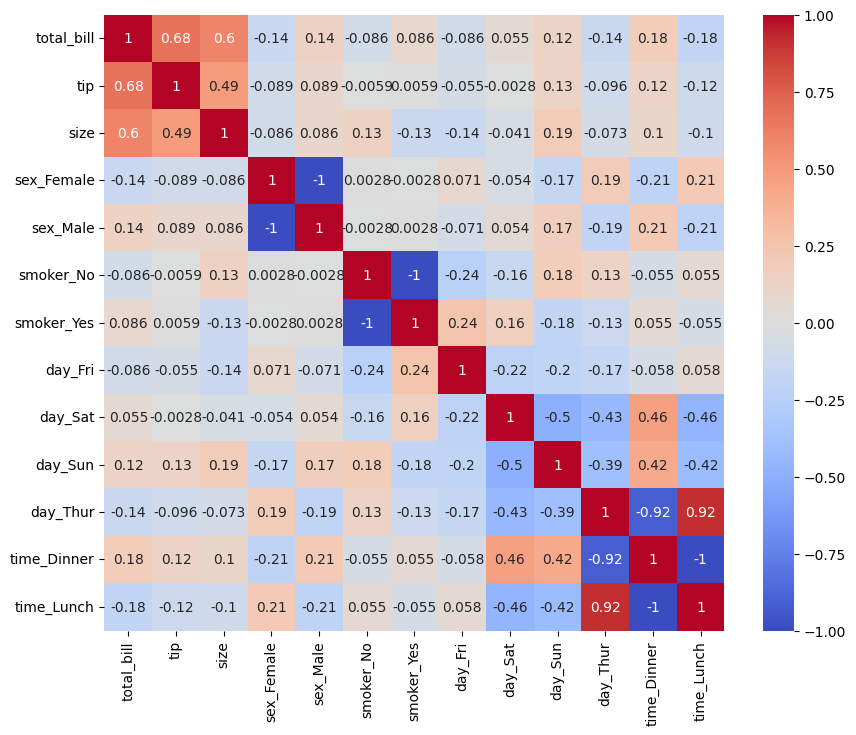

In [38]:
# Primero vamos a ver las correlaciones entre las variables
# Convertimos las variables categóricas en variables numéricas con get_dummies
df_encoded: pd.DataFrame = pd.get_dummies(df_null)

# Generamos la grafica de correlacion
correlation: pd.DataFrame = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

<a id='tratado_null_second_total_bill'></a>

<font color='118ab2'>

##### Comenzaremos con el relleno de los valores nulos en "total_bill"

</font>


Con la grafica anterior podemos diferenciar varias cosas:
* _Disclamer: lo mas optimo seria usar TIP y SIZE para calcular la aproximacion del total-bill, pero el uso de variables numericas para el calculo de datos lo hacemos en el siguiente ejemplo con el tip_
1. La diferencia entre fumadores y no fumadores es practicamente nula
2. La diferencia entre Hombres y mujeres si que puede llegarse a considerar en el relleno de datos ya que, de -0.14 a 0.14 tenemos una diferencia a considerar, no es exagerada pero si interesante
3. En las diferencias entre si es comida o cena tambien hay una diferencia considerable


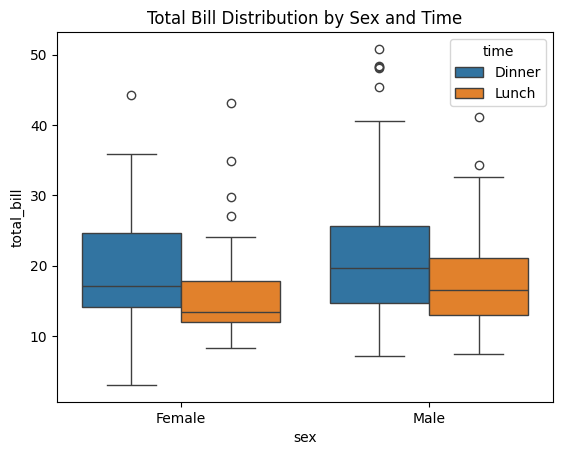

In [39]:
# Primero para confirmar haremos un boxplot de las variables sexo y total_bill y colorearemos por la variable time
sns.boxplot(x='sex', y='total_bill', hue='time', data=df_null)
plt.title('Total Bill Distribution by Sex and Time')
plt.show()

Tras el boxplot podemos asumir que si tiene un impacto destacable tanto el Time como el Sexo, asi mismo podemos ver que hay una buena cantidad de outliers por lo que debemos tener en cuenta a futuro de o bien normalizarlos o en lugar de usar la media usar la mediana

In [40]:
#Una vez visualizado generamos los 4 dataframes para sacar las medianas y rellenar los datos null
df_male: pd.DataFrame = df[df['sex'] == 'Male']
#Separacion entre smokers y non-smokers
df_male_dinner: pd.DataFrame = df_male[df_male['time'] == 'Dinner']
df_male_lunch: pd.DataFrame = df_male[df_male['time'] == 'Lunch']

#Para female
df_female: pd.DataFrame = df[df['sex'] == 'Female']
#Separacion entre smokers y non-smokers
df_female_dinner: pd.DataFrame = df_female[df_female['time'] == 'Dinner']
df_female_lunch: pd.DataFrame = df_female[df_female['time'] == 'Lunch']

df_male_dinner['total_bill'].describe()

count    124.000000
mean      21.461452
std        9.460974
min        7.250000
25%       14.705000
50%       19.630000
75%       25.642500
max       50.810000
Name: total_bill, dtype: float64

In [41]:
df_male_lunch['total_bill'].describe()

count    33.000000
mean     18.048485
std       7.953435
min       7.510000
25%      13.030000
50%      16.580000
75%      21.160000
max      41.190000
Name: total_bill, dtype: float64

In [42]:
df_female_dinner['total_bill'].describe()

count    52.000000
mean     19.213077
std       8.202085
min       3.070000
25%      14.080000
50%      17.190000
75%      24.692500
max      44.300000
Name: total_bill, dtype: float64

In [43]:
df_female_lunch['total_bill'].describe()

count    35.000000
mean     16.339143
std       7.500803
min       8.350000
25%      12.065000
50%      13.420000
75%      17.865000
max      43.110000
Name: total_bill, dtype: float64

In [44]:
# rellenamos los datos null con las medianas en el df original
# hacemos uso de el metodo loc para localizar los valores que cumplen las condiciones que necesitamos
# algo asi como un where en SQL o un if con multiples condiciones
# vamos a añadirle un pequeño ajuste para que no afecte a la moda sumandole el 1% del valor del tip en caso de que el tip no sea null
df.loc[(df['total_bill'].isnull()) & \
    (df['sex'] == 'Female') & \
    (df['time'] == 'Dinner'), 'total_bill'] = df_female_dinner['total_bill'].median() + 0.1 * df['tip']

df.loc[(df['total_bill'].isnull()) & \
    (df['sex'] == 'Female') & \
    (df['time'] == 'Lunch'), 'total_bill'] = df_female_lunch['total_bill'].median() + 0.1 * df['tip']

df.loc[(df['total_bill'].isnull()) & \
    (df['sex'] == 'Male') & \
    (df['time'] == 'Dinner'), 'total_bill'] = df_male_dinner['total_bill'].median() + 0.1 * df['tip']

df.loc[(df['total_bill'].isnull()) & \
    (df['sex'] == 'Male') & \
    (df['time'] == 'Lunch'), 'total_bill'] = df_male_lunch['total_bill'].median() + 0.1 * df['tip']

---------------

<a id='tratado_null_second_tip'></a>

<font color='118ab2'>

##### Comenzaremos con el relleno de los valores nulos en "TIP"

</font>

Ahora realizaremos un procedimiento similar al anterior dado que es otra variable numerica y identificaremos donde estan las mayores correlaciones de los TIPs, en este caso usaremos la variable numerica ya tratada "total_bill"

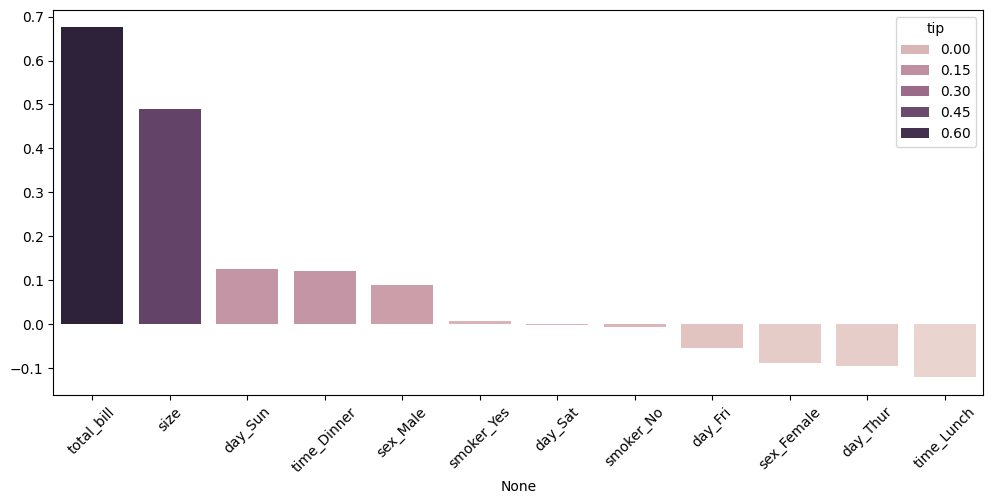

In [45]:
corr_price: pd.DataFrame = correlation['tip'] # filtrar correlación precio
corr_price = corr_price.sort_values(ascending=False)[1:] # ordenar descendente
plt.figure(figsize=(12, 5))
sns.barplot(x=corr_price.index, y=corr_price.values , hue=corr_price)
plt.xticks(rotation=45);

Podemos identificar claramente como el total_bill y el size tienen una fuerte correlacion con el tip final, por lo que haremos un pequeño calculo para aproximar los valores null a algo real

Usaremos Bins (Para asi crear rangos de valores, en el caso de el totalbill que tiene mas variacion usaremos 10 rangos de valores, mientras que en el size usaremos solo 5)

In [46]:
# Para no usar regresion aqui dado que aun no es una parte que se haya visto en clase, usaremos bins par ahacer un calculo mas sencillo
# y no tener que hacer una regresion lineal

N_TOTAL_BILL_BINS: int = 10
N_SIZE_BINS: int = 5

# Group the data into bins and calculate the mean of the tips for each group
bins_total_bill: pd.Series = pd.cut(df_null['total_bill'], bins=N_TOTAL_BILL_BINS)
bins_size: pd.Series = pd.cut(df_null['size'], bins=N_SIZE_BINS)

# Combine the bins into a DataFrame to be able to calculate the mean
grouping: pd.DataFrame = pd.DataFrame({'total_bill_bin': bins_total_bill, 'size_bin': bins_size})

# Calculate the mean of the tips for each group
mean_tips: pd.Series = df_null.groupby([bins_total_bill, bins_size], observed=True)['tip'].mean()

# Define a function that imputes the tip in case it is null
def impute_tip(row: pd.Series) -> Union[float, pd.Series]:
    if pd.isna(row['tip']):
        total_bill_bin: pd.Series = pd.cut([row['total_bill']], bins=N_TOTAL_BILL_BINS)[0]
        size_bin: pd.Series = pd.cut([row['size']], bins=N_SIZE_BINS)[0]
        return mean_tips[total_bill_bin, size_bin]
    return row['tip']

# Launch the function against all the values to impute the null values, it does not affect the non-null ones
df_null['tip'] = df_null.apply(impute_tip, axis=1)

------------

<a id='tratado_null_second_smoke'></a>

<font color='118ab2'>

##### Comenzaremos con el relleno de los valores nulos en "SMOKE"

</font>

Primero sacamos las correlaciones de smoke para tenerlas de nuevo a mano y mas visibles

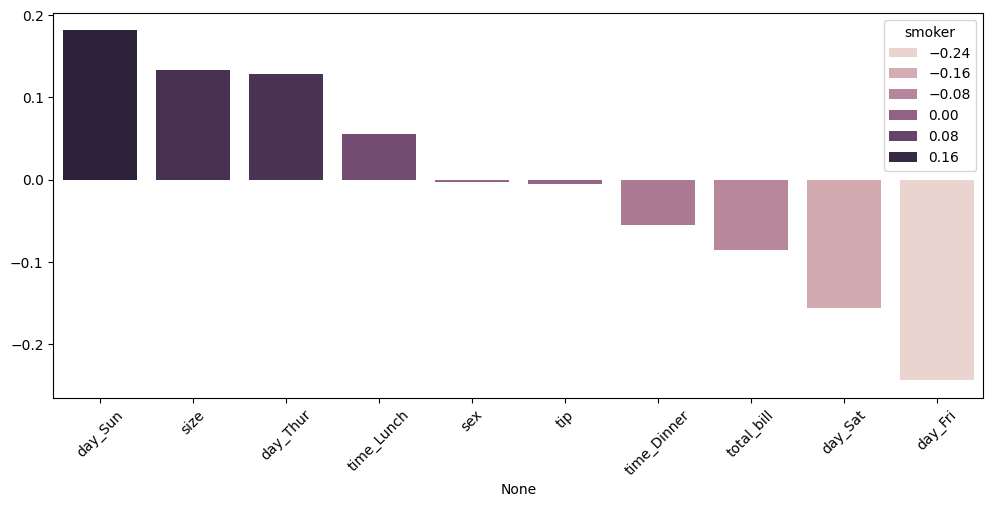

In [47]:
# Convert the categorical variable to a binary variable
df_smoke: pd.DataFrame = df_null.copy()
df_smoke['smoker'] = df_smoke['smoker'].map({'Yes': 0, 'No': 1})
df_smoke['sex'] = df_smoke['sex'].map({'Female': 0, 'Male': 1})
df_smoke_encoded: pd.DataFrame = pd.get_dummies(df_smoke)
# Compute the correlation matrix
correlation_smoker: pd.DataFrame = df_smoke_encoded.corr()
corr_smoker: pd.DataFrame = correlation_smoker['smoker'] # filtrar correlación precio
corr_smoker = corr_smoker.sort_values(ascending=False)[1:] # ordenar descendente
plt.figure(figsize=(12, 5))
sns.barplot(x=corr_smoker.index, y=corr_smoker.values , hue=corr_smoker)
plt.xticks(rotation=45);

Podemos ver que el que la persona sea o no fumadora no tiene mucha correlacion, no llegando ninguna variable a 0.2 de correlacion. Por lo que procederemos a rellenarlos de manera aleatoria con fumadores o no fumadores.

In [48]:
choices = ["Yes", "No"]

df_null["smoker"] = df_null["smoker"].apply(
        lambda x: random.choice(choices) if pd.isnull(x) else x
    )

-----

Con esto acabamos la parte del tratado de nulos **SIN REGRESION LINEAL** _mas adelante cuando tratemos las regresiones lineales haremos el tratado de nulos numericos con una regresion para predicir valores más acertados_
Nos aseguraremos de que todos los nulls esten bien tratados:

In [49]:
df = df_null.copy()
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

------------


<a id='exploracion_datos'></a>

<font color='ffd166'> 

###  Exploración de datos 

</font>

Tras el correspondiente tratado de datos nulls comenzamos con la exploracion de datos, en este caso centrandonos en los Tips y el valor total. 
lo primero volveremos a realizar: 

1. Describe: Para estudiar las diferentes variables del dataset
2. BoxPlox: Para identificar los outliers dentro de ambas variables e identificar como proceder con ellos
3. 

In [50]:
#Generacion de la tabla de correlaciones para trabajar con ella a futuro
df_copy = df.copy()
df_encoded: pd.DataFrame = pd.get_dummies(df_copy)

# Generamos la grafica de correlacion
correlation: pd.DataFrame = df_encoded.corr()

df.describe(include='all')

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244,244,244,244,244.000000
unique,NaN,NaN,2,2,4,2,NaN
top,NaN,NaN,Male,No,Sat,Dinner,NaN
freq,NaN,NaN,157,151,87,176,NaN
mean,19.785943,2.998279,NaN,NaN,NaN,NaN,2.569672
std,8.902412,1.383638,NaN,NaN,NaN,NaN,0.951100
min,3.070000,1.000000,NaN,NaN,NaN,NaN,1.000000
25%,13.347500,2.000000,NaN,NaN,NaN,NaN,2.000000
50%,17.795000,2.900000,NaN,NaN,NaN,NaN,2.000000
75%,24.127500,3.562500,NaN,NaN,NaN,NaN,3.000000


<font color='ffd166'>

### Exploracion de datos de TIP

</font>



<div class="alert alert-block alert-danger">
    <b>Disclamer:</b> Esta primera parte no seria necesaria al estar en el mismo archivo, pero se hara ya que en el formato real este estudio estaria en un archivo diferente al tratado de los nulls
</div>

Mostraremos la correlacion de tip con el resto de columnas. Para identificar cuales son las que mas influencia tienen


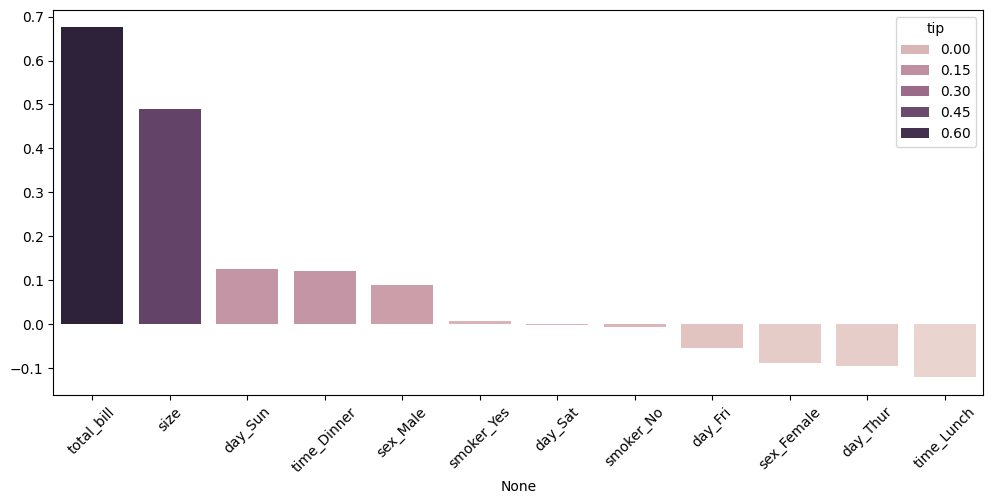

In [51]:
corr_price: pd.DataFrame = correlation['tip'] # filtrar correlación precio
corr_price = corr_price.sort_values(ascending=False)[1:] # ordenar descendente
plt.figure(figsize=(12, 5))
sns.barplot(x=corr_price.index, y=corr_price.values , hue=corr_price)
plt.xticks(rotation=45);

Se puede ver como claramete la mayor influencia sobre el tip son el size y el total_bill, por lo que vamos a explorar un boxplot de los 3, para identificar la influencia de los outliers y decidir como tratarlos

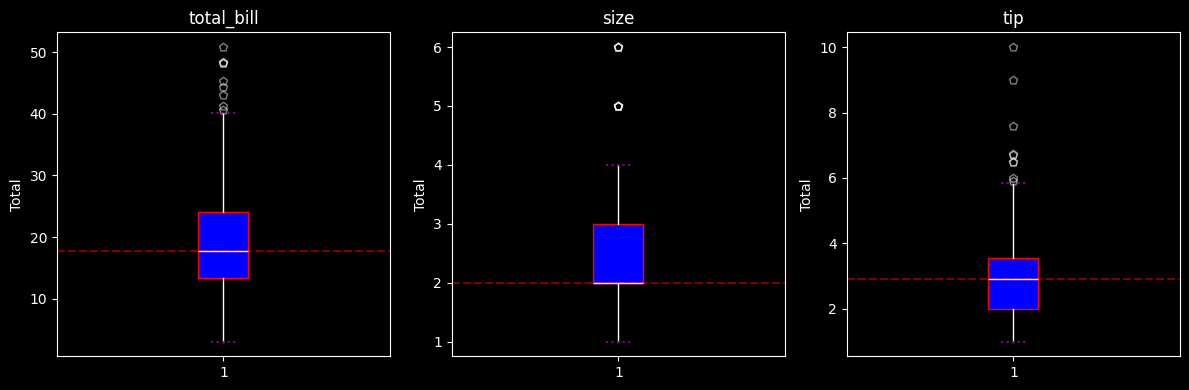

In [52]:

#Get the columns to work with
columns_to_plot: list[str] = ['total_bill', 'size', 'tip']
working_df: pd.DataFrame = df[columns_to_plot]


#to avoid superpose of past styles first set the default and then the one you want
plt.style.use('default')
plt.style.use('dark_background')



medians: pd.Series = df[columns_to_plot].median()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
boxplots: list[dict] = []

# Boxplot generation
for i, column in enumerate(columns_to_plot):
    # The patch artist is to allow the custom inner colors in the boxplot
    boxplot = axes[i].boxplot(df[column], patch_artist=True)
    boxplots.append(boxplot)
    axes[i].set_title(column)
    axes[i].axhline(y=medians.iloc[i], color='red', alpha=0.5,  linestyle='--')
    axes[i].add_patch

# Label for all axis
for ax in axes:
    ax.set_ylabel('Total')

# Custom boxplots
for boxplot in boxplots:
    for cap in boxplot['caps']:
        cap.set(color ='#8B008B', linewidth = 1.5, linestyle =":")
    
    #Custom outliers
    for flier in boxplot['fliers']:
        flier.set(marker =(5, 0),
                color ='#e7298a',
                alpha = 0.5)

    for box in boxplot['boxes']:
        box.set(color="red")
        box.set_facecolor("blue")
# adjust the spacing
plt.tight_layout()
plt.show()

In [55]:
from lib.df_utils import get_outliers_multiple_w_iqr
#show how many outliers in each column
outliers: pd.DataFrame = get_outliers_multiple_w_iqr(working_df)

#show quantity of outliers for each column
outliers.count()


ImportError: cannot import name 'get_outliers_multiple_w_iqr' from 'lib.df_utils' (e:\workspace\estudio_workspace\ProgramaIA_DS\Codigo\Python\EjerciciosPostgrado\LyD_IA\Entregas\Tips\py\lib\df_utils.py)